## In this part, a second modeling using SMOTE oversampling is performed to see if by balancing the training data, we can get better metrics!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report

In [2]:
df=  pd.read_csv('Voices_Cleaned1.csv', index_col=0)

In [3]:
df= df.drop(columns=['date','age','user','pronounce'])

In [4]:
model_features = ['mean','std','median','first_q', 'third_q', 'inter_q', 'skewness', 'kurtosis','mode','peak']

In [5]:
df.sex = df.sex.astype(int)

In [6]:
oversample = SMOTE(random_state=23)

In [7]:
def data_prepration(x): 
    x_features= x.loc[:,x.columns != "sex"]
    x_labels=x.loc[:,x.columns=="sex"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.2)
    print("length of training data")
    print(len(x_features_train))
    print("length of testing data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [8]:
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(df)

length of training data
4216
length of testing data
1055


In [9]:
columns = data_train_X.columns

In [10]:
os_data_X,os_data_y=oversample.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["sex"])

print("length of oversampled data is ",len(os_data_X))
print("Number of males in oversampled data",len(os_data_y[os_data_y["sex"]==0]))
print("No.of females in oversampled data",len(os_data_y[os_data_y["sex"]==1]))

length of oversampled data is  7822
Number of males in oversampled data 3911
No.of females in oversampled data 3911


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
scaler = StandardScaler()
scaler.fit(df.loc[:,model_features]) 
X_train = scaler.transform(os_data_X.loc[:,model_features])
X_test = scaler.transform(data_test_X.loc[:,model_features])
y_train = list(os_data_y['sex'].values)
y_test = list(data_test_y['sex'].values)

In [12]:
#Train decision tree model
tree = DecisionTreeClassifier(random_state=23).fit(X_train, y_train)
print('Decision Tree Report')
print('train score is %s' %tree.score(X_train, y_train))
print('test score is %s' %tree.score(X_test, y_test))



#Train random forest model
forest = RandomForestClassifier(n_estimators=100, random_state=23).fit(X_train, y_train)
print('Random Forests Report')
print('train score is %s' %forest.score(X_train, y_train))
print('test score is %s' %forest.score(X_test, y_test))


#Train gradient boosting model
gb = GradientBoostingClassifier(random_state=23).fit(X_train, y_train)
print('Gradient Boosting Report')
print('train score is %s' %gb.score(X_train, y_train))
print('test score is %s' %gb.score(X_test, y_test))


Decision Tree Report
train score is 1.0
test score is 0.8691943127962085
Random Forests Report
train score is 1.0
test score is 0.8890995260663507
Gradient Boosting Report
train score is 0.9121708003068268
test score is 0.8578199052132701


In [13]:
def create_report(model,X_train,X_test,y_train,y_test):
    clf= model
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    metrics_matrix=confusion_matrix(y_test,pred)
    print("the accuracy for this model is :",(metrics_matrix[0,0]+metrics_matrix[1,1])/(metrics_matrix[0,0]+metrics_matrix[0,1]+metrics_matrix[1,0]+metrics_matrix[1,1]))
    print("the recall for this model is :",metrics_matrix[1,1]/(metrics_matrix[1,1]+metrics_matrix[1,0]))

    fig= plt.figure(figsize=(6,3))
    print("TP",metrics_matrix[1,1]) 
    print("TN",metrics_matrix[0,0]) 
    print("FP",metrics_matrix[0,1]) 
    print("FN",metrics_matrix[1,0])
    sns.heatmap(metrics_matrix,cmap="coolwarm",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_Sex")
    plt.ylabel("Real_Sex")
    plt.show()
    print("\n----------Classification Report----------")
    print(classification_report(y_test,pred))


the accuracy for this model is : 0.8691943127962085
the recall for this model is : 0.44871794871794873
TP 35
TN 882
FP 95
FN 43


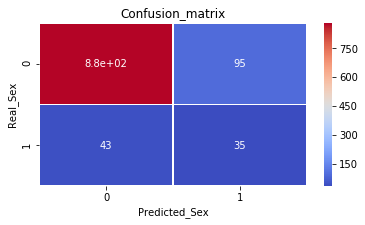


----------Classification Report----------
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       977
           1       0.27      0.45      0.34        78

   micro avg       0.87      0.87      0.87      1055
   macro avg       0.61      0.68      0.63      1055
weighted avg       0.90      0.87      0.88      1055



In [14]:
create_report(DecisionTreeClassifier(random_state=23),X_train,X_test,y_train,y_test)

the accuracy for this model is : 0.8890995260663507
the recall for this model is : 0.5128205128205128
TP 40
TN 898
FP 79
FN 38


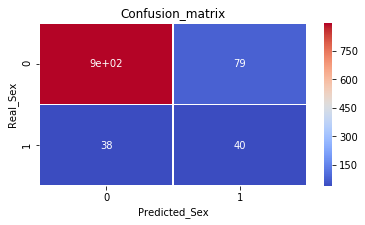


----------Classification Report----------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       977
           1       0.34      0.51      0.41        78

   micro avg       0.89      0.89      0.89      1055
   macro avg       0.65      0.72      0.67      1055
weighted avg       0.91      0.89      0.90      1055



In [15]:
create_report(RandomForestClassifier(n_estimators=100,random_state=23),X_train,X_test,y_train,y_test)

the accuracy for this model is : 0.8578199052132701
the recall for this model is : 0.7435897435897436
TP 58
TN 847
FP 130
FN 20


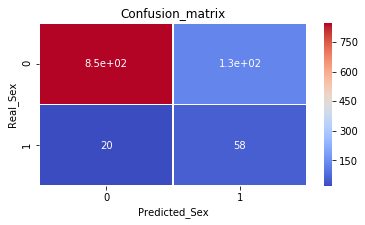


----------Classification Report----------
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       977
           1       0.31      0.74      0.44        78

   micro avg       0.86      0.86      0.86      1055
   macro avg       0.64      0.81      0.68      1055
weighted avg       0.93      0.86      0.88      1055



In [16]:
create_report(GradientBoostingClassifier(random_state=23),X_train,X_test,y_train,y_test)

In [17]:
def importances_graphs(model):
    number_features = len(model_features)
    plt.figure(1,figsize=(16,8))
    plt.bar(range(number_features), model.feature_importances_, align='center')
    plt.xticks(np.arange(number_features), model_features)
    plt.ylabel("Importance")
    plt.xlabel("Feature ")
    plt.title(model.__class__.__name__)
    plt.show()

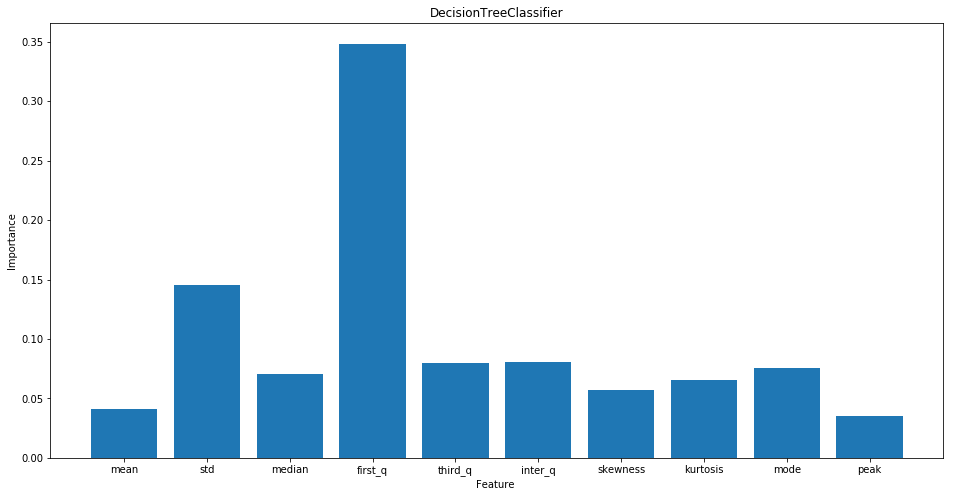

In [18]:
importances_graphs(tree)

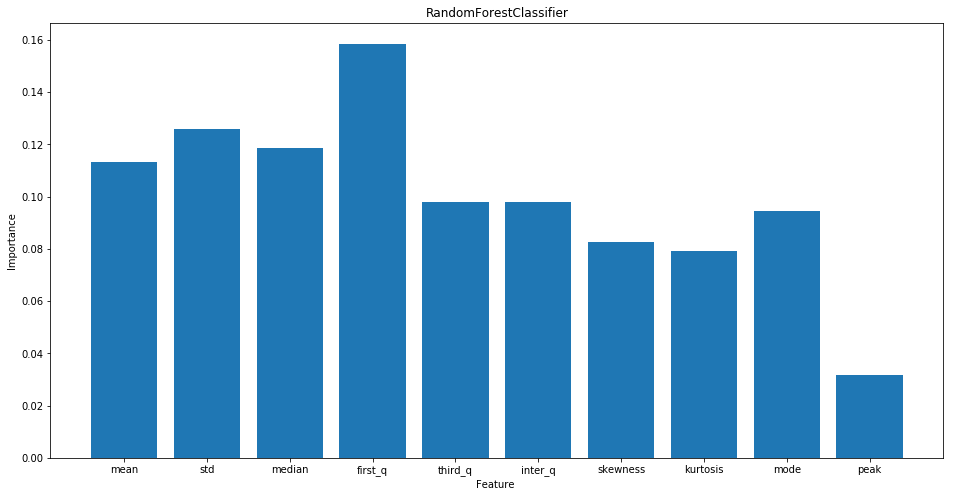

In [19]:
importances_graphs(forest)

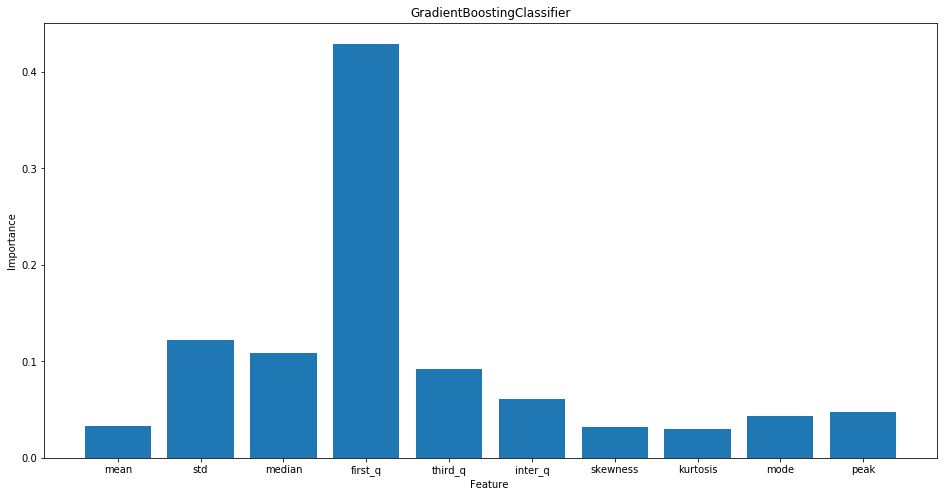

In [20]:
importances_graphs(gb)

## Here I have tried to tune for different important metrics for both Random Forest & Gradiant Boosting models:





## 1- for random forest model I have first performed a random search and then based on its output created a grid search.



In [34]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [37]:
rf= RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=23, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/skl

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=23, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [38]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [43]:
scores = ['precision','recall','f1']
parameters = {
    'bootstrap': [False],
    'max_depth': [ 100,110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2, 3],
    'n_estimators': [200,210],
    'random_state':[23]
}

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5,n_jobs=-1,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 23}

Grid scores on development set:

0.951 (+/-0.022) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 23}
0.951 (+/-0.024) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 210, 'random_state': 23}
0.950 (+/-0.023) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 23}
0.950 (+/-0.022) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 210, 'random_state': 23}
0.948 (+/-0.018) for {'bootstrap': Fals

# --------------------------------------------------------------------------------------------

## 2- A try to see if it is possible to reach better parameters for GB model! This is not well performed due to time limitation at this step, I just have done a simple grid search with a guess ed set of starting parameters!

In [44]:
scores = ['precision','recall','f1']
parameters = {
    "loss":["exponential","deviance"],
    "learning_rate": [0.4,0.5],
    "min_samples_split": np.linspace(0.01, 0.2, 2),
    "min_samples_leaf": np.linspace(0.01, 0.2, 2),
    "max_depth":[9,11],
    "max_features":["log2"],
    "criterion": ["friedman_mse"],
    "subsample":[0.4,0.6],
    "n_estimators":[90,110],
    "random_state" : [23]
    }

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,n_jobs=-1,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 110, 'random_state': 23, 'subsample': 0.6}

Grid scores on development set:

0.935 (+/-0.025) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.4}
0.943 (+/-0.028) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.6}
0.937 (+/-0.024) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 

Best parameters set found on development set:

{'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 110, 'random_state': 23, 'subsample': 0.6}

Grid scores on development set:

0.934 (+/-0.024) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.4}
0.941 (+/-0.027) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.6}
0.936 (+/-0.023) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estim

Best parameters set found on development set:

{'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 110, 'random_state': 23, 'subsample': 0.6}

Grid scores on development set:

0.933 (+/-0.024) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.4}
0.941 (+/-0.027) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 90, 'random_state': 23, 'subsample': 0.6}
0.936 (+/-0.023) for {'criterion': 'friedman_mse', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estim

Conclusion : Among these models still the base model are performing better!